In [33]:
import pandas as pd
import numpy as np

# Packages for Image clustering
from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm


# Sklearn Packages
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil
from sklearn.cluster import KMeans

In [2]:
# Import the Dataset
# CDR --> Clinical Dementia rating
# MMSE --> Mini mental state evaluation
# SES --> socioeconomic status
# eTIV --> Estimated intracranial volume
# nWBV --> normalize whole brain volume
cross_section = pd.read_csv('./AlzheimersDataset/oasis_cross-sectional.csv')
longitudinal = pd.read_csv('./AlzheimersDataset/oasis_longitudinal.csv')

In [ ]:
# Clean the NaN data
longitudinal = longitudinal.dropna()
longitudinal.pop('Subject ID')
longitudinal.pop('MRI ID')

In [4]:
# Convert Categorical columns to numeric
columns = ['M/F', 'Hand']
# columns = ['M/F', 'Group', 'Hand']

# M = 0; F = 1
# Nondemented = 0; Demented = 1
# Right handed = 0

y = longitudinal.pop('Group')

for column in columns:
    longitudinal[column] = pd.factorize(longitudinal[column])[0]

x = longitudinal

In [5]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))

283 71 283 71


In [6]:
# Scaling X_train
scaler = preprocessing.StandardScaler().fit(X_train)

X_scaled = scaler.transform(X_train)


In [7]:
# Find the best combinationo of parameters for the algorithm

# param_grid = [
#         {
#             'activation' : ['identity', 'logistic', 'tanh', 'relu'],
#             'solver' : ['lbfgs', 'sgd', 'adam'],
#             'hidden_layer_sizes': [
#              (1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)
#              ]
#         }
#        ]


# clf = GridSearchCV(MLPClassifier(max_iter=5000), param_grid, cv=3, scoring='accuracy')

# clf.fit(X_scaled, y_train)

# print("Best parameters set found on development set:")
# print(clf.best_params_)

# ---------- RETURNS ------------------
# Best parameters set found on development set:
# {'activation': 'identity', 'hidden_layer_sizes': (16,), 'solver': 'sgd'}


In [8]:
clf = MLPClassifier(activation='identity', solver='sgd', hidden_layer_sizes=(16,), random_state=1, max_iter=5000)

clf.fit(X_scaled, y_train)

MLPClassifier(activation='identity', hidden_layer_sizes=(16,), max_iter=5000,
              random_state=1, solver='sgd')

In [10]:
# Check the model accuracy

test_scaled = scaler.transform(X_test)

print( 'accuracy: ', clf.score(test_scaled, y_test))

accuracy:  0.9014084507042254


In [49]:
# Data Viz
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

# ax = plt.subplot()
# X_train[0]

# plt.scatter(
#             X_train[:, 0],
#             X_train[:, 1],
#             c=y_train,
#             cmap=cm_bright,
#             edgecolors="black",
#             s=25,
#         )
#         # and testing points
# plt.scatter(
#     X_test[:, 0],
#     X_test[:, 1],
#     c=y_test,
#     cmap=cm_bright,
#     alpha=0.6,
#     edgecolors="black",
#     s=25,
# )
# plt.show
test_scaled[0]

array([ 0.1553237 ,  0.283279  , -1.20866437,  0.        ,  0.75077953,
       -1.29102412,  1.33044683,  0.41935158, -0.7180043 ,  1.41913688,
       -1.60978771, -1.35352199])

In [ ]:
# Dimensionality Reduction

pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_scaled)

print('Shape before PCA: ', test_scaled.shape)
print('Shape after PCA: ', pca_features.shape)

pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])

pca_features

In [114]:
# Unsupervised clustering of training data
db = DBSCAN(min_samples=12, eps=0.5).fit(pca_features)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 136


In [117]:
y_train


371    Nondemented
213    Nondemented
362    Nondemented
190    Nondemented
81       Converted
          ...     
77        Demented
112    Nondemented
282    Nondemented
367       Demented
108    Nondemented
Name: Group, Length: 283, dtype: object

In [115]:
cluster_a = []
cluster_b = []
noise = []

for i in range(len(labels)):
    label = labels[i]
    item = pca_features[i]
    truth = 'yellow' if y_train[i] == 'Demented' else 'black'
    if label == -1:
        noise.append(item)
    elif label == 0:
        cluster_a.append(item)
    elif label == 1:
        cluster_b.append(item)
    else:
        print('Catch clause')
        

Catch clause
Catch clause
Catch clause
Catch clause
Catch clause
Catch clause
Catch clause


<function matplotlib.pyplot.show(close=None, block=None)>

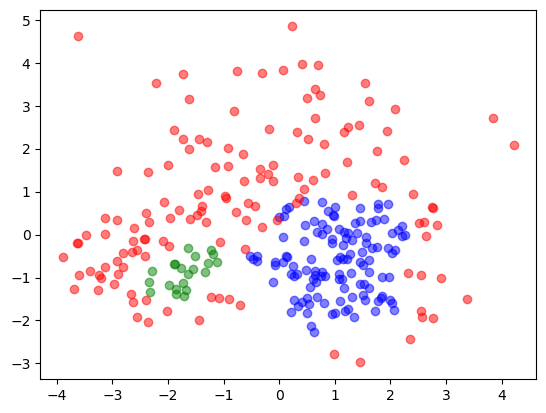

In [116]:
# Graph the DBSCAN clusters
cluster_a_df = pd.DataFrame(cluster_a, columns = ['x','y'])
cluster_b_df = pd.DataFrame(cluster_b, columns = ['x','y'])
noise_df = pd.DataFrame(noise, columns = ['x','y'])


plt.scatter(cluster_a_df['x'], cluster_a_df['y'], c='blue', edgecolors= alpha=0.5)
plt.scatter(cluster_b_df['x'], cluster_b_df['y'], c='green', alpha=0.5)
plt.scatter(noise_df['x'], noise_df['y'], c='red', alpha=0.5)

plt.show
